# Assignment 2: The "Smart Labeling Pipeline" Challenge

**Total Marks: 20**

Build a cost-effective, high-quality labeling pipeline using human annotation, programmatic rules, and LLMs.

This notebook implements an end-to-end smart labeling pipeline to:
1. Establish gold standard through human annotation and measure inter-annotator agreement (6 marks)
2. Label data programmatically using weak supervision (Snorkel) (6 marks)
3. Optimize labeling budget using active learning (5 marks)
4. Leverage LLMs for bulk labeling and detect hallucinations (e.g. noisy labels) (3 marks)

## Setup and Imports

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel
from statsmodels.stats.inter_rater import fleiss_kappa
# import google.generativeai as genai
import time
from pathlib import Path
import re

## Task 1: The Human as Annotator (6 Marks)

**Objective:** Establish a "Gold Standard" dataset and measure human consensus.

### Part 1.1: Parse Annotator CSV Files

After annotating the first 100 reviews, export annotations from three annotators (A, B, C) as CSV files.
Parse these CSV files into clean DataFrames for analysis.

In [97]:
def parse_annotator_csv(csv_path):
    """
    Parses annotator CSV file into a clean DataFrame.

    Args:
        csv_path (str): Path to annotator CSV file
    Returns:
        pd.DataFrame: DataFrame with columns ['review_id', 'review', 'label']
                     where label is one of: 'Positive', 'Negative', 'Neutral'

    Note:
        - Look for relevant column names in the CSV file
        - If column names differ, the function will try to map them appropriately
        - Finally, return with two columns 'review' and 'label'
    """
    # TODO: Load CSV file using pd.read_csv()
    df = pd.read_csv(csv_path)

    # TODO: Check and map column names if needed
    columnMapping = {
        'sentiment': 'label'
    }

    df = df.rename(columns=columnMapping)
    return df[['review', 'label']]
    pass

In [98]:
# TODO: Parse CSV files (replace with actual file paths)
fileA = "annotator_a.csv"
fileB = "annotator_b.csv"
fileC = "annotator_c.csv"
# Display sample data

dfA = parse_annotator_csv(fileA)
dfB = parse_annotator_csv(fileB)
dfC = parse_annotator_csv(fileC)

dfA.head()

,review,label
0,This movie is a triumph in every sense. Highly...,Positive
1,I have never been so bored in my life. The sco...,Negative
2,I was completely blown away by this film. The ...,Positive
3,The trailer was better than the movie. The act...,Negative
4,Middle of the road entertainment. Visually it'...,Neutral


In [99]:
dfB.head()

,review,label
0,This movie is a triumph in every sense. Highly...,Positive
1,I have never been so bored in my life. The sco...,Negative
2,I was completely blown away by this film. The ...,Neutral
3,The trailer was better than the movie. The act...,Neutral
4,Middle of the road entertainment. Visually it'...,Neutral


In [100]:
dfC.head()

,review,label
0,This movie is a triumph in every sense. Highly...,Positive
1,I have never been so bored in my life. The sco...,Negative
2,I was completely blown away by this film. The ...,Positive
3,The trailer was better than the movie. The act...,Negative
4,"""Middle of the road entertainment. Visually it...",Neutral


### Part 1.2: Implement Fleiss' Kappa from Scratch

Measure inter-annotator agreement using Fleiss' Kappa statistic.
Implement the formula from scratch and compare with statsmodels implementation.

In [101]:
def fleiss_kappa_scratch(rating_matrix):
    """
    Computes Fleiss' Kappa for multiple raters from scratch.

    Args:
        rating_matrix (np.array): A Count Matrix of shape (N, k).
                                  - N = number of items (rows)
                                  - k = number of categories (columns)
                                  - Element [i, j] = Count of raters who assigned category j to item i.
                                  Example:
                                    [[0, 0, 3],   # Item 0: All 3 raters said Category 2
                                     [1, 2, 0]]   # Item 1: 1 rater said Cat 0, 2 said Cat 1


    Returns:
        float: Kappa score (ranges from -1 to 1, where 1 = perfect agreement)

    Formula:
        κ = (P_bar - P_e_bar) / (1 - P_e_bar)

        where:
        - P_bar = (1/N) * Σ(P_i) = average proportion of agreement across all items
        - P_i = (1/(n*(n-1))) * Σ(k_ij * (k_ij - 1)) for item i
        - P_e_bar = Σ(p_j^2) = expected agreement by chance
        - p_j = proportion of all assignments to category j

    Note:
        - N = number of items (samples)
        - n = number of raters per item (should be constant)
        - k_ij = number of raters who assigned category j to item i
    """
    # TODO: Calculate P_bar (observed agreement), P_e_bar (expected agreement by chance), Apply the formula: κ = (P_bar - P_e_bar) / (1 - P_e_bar)
    N, k =rating_matrix.shape
    n = np.sum(rating_matrix[0])

    P_i = (np.sum(rating_matrix**2, axis=1) - n) / (n * (n - 1))
    P_bar = np.mean(P_i)
    P_j = np.sum(rating_matrix, axis=0) / (N * n)
    P_e_bar = np.sum(P_j**2)

    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    return kappa
    pass

In [102]:
def prepare_rating_matrix(df_a, df_b, df_c):
    """
    Converts three DataFrames into a rating matrix for Fleiss' Kappa calculation.

    Args:
        df_a, df_b, df_c: DataFrames with columns ['review_id', 'review', 'label']

    Returns:
        np.array: Rating matrix of shape (N_samples, N_categories)
                  where categories are ['Negative', 'Neutral', 'Positive']
    """
    # TODO: Merge the three DataFrames on review
    # Hint: Use pd.merge() or pd.concat() with proper keys
    merged = df_a.merge(df_b, on='review', suffixes=('A', 'B'))
    merged = merged.merge(df_c, on='review')
    merged.rename(columns={'label': 'labelC'}, inplace=True)

    categories = ['Negative', 'Neutral', 'Positive']
    
    # TODO: Return numpy array of shape (N_samples, 3)
    # Order: [Negative_count, Neutral_count, Positive_count] for each row
    ratingMatrix = []
    for dummy, row in merged.iterrows():
        labels = [row['labelA'], row['labelB'], row['labelC']]
        counts = [labels.count(category) for category in categories]
        ratingMatrix.append(counts)

    return np.array(ratingMatrix)
    pass

# TODO: Prepare rating matrix and calculate Fleiss' Kappa

# TODO: Use statsmodels to calculate Fleiss' Kappa

# TODO: Print the difference between the two implementations
ratingMatrix = prepare_rating_matrix(dfA,dfB,dfC)
ratingMatrix

array([[0, 0, 3],
       [3, 0, 0],
       [0, 1, 2],
       [2, 1, 0],
       [0, 0, 3],
       [3, 0, 0],
       [3, 0, 0],
       [0, 3, 0],
       [3, 0, 0],
       [0, 0, 3],
       [0, 3, 0],
       [0, 3, 0],
       [0, 0, 3],
       [0, 0, 3],
       [3, 0, 0],
       [0, 1, 2],
       [3, 0, 0],
       [3, 0, 0],
       [0, 0, 3],
       [3, 0, 0],
       [0, 3, 0],
       [0, 0, 3],
       [3, 0, 0],
       [0, 0, 3],
       [0, 3, 0],
       [0, 0, 3],
       [3, 0, 0],
       [3, 0, 0],
       [0, 2, 1],
       [3, 0, 0],
       [0, 3, 0],
       [0, 3, 0],
       [3, 0, 0],
       [3, 0, 0],
       [0, 0, 3],
       [0, 0, 3],
       [0, 0, 3],
       [0, 2, 1],
       [3, 0, 0],
       [0, 3, 0],
       [0, 3, 0],
       [3, 0, 0],
       [0, 0, 3],
       [3, 0, 0],
       [3, 0, 0],
       [3, 0, 0],
       [0, 0, 3],
       [0, 0, 3],
       [0, 0, 3],
       [0, 3, 0],
       [0, 0, 3]])

In [103]:
kappaApna = fleiss_kappa_scratch(ratingMatrix)
kappaFirangi = fleiss_kappa(ratingMatrix)

print("Kappa score (scratch implementation):", kappaApna)
print("Kappa score (statsmodels):", kappaFirangi)
print("Difference:", abs(kappaApna - kappaFirangi))

Kappa score (scratch implementation): 0.9000653167864141
Kappa score (statsmodels): 0.9000653167864141
Difference: 0.0


### Part 1.3: Conflict Resolution

Identify conflicts where annotators disagree and resolve them using majority vote.
For complete ties (all three differ), default to 'Neutral'.

In [104]:
from statistics import multimode
def resolve_conflicts(df_a, df_b, df_c):
    """
    Merges annotations from 3 annotators, resolves disagreements using Majority Vote,
    and handles complete ties by defaulting to 'Neutral'.

    Args:
        df_a, df_b, df_c: DataFrames from each annotator with columns ['review', 'label']

    Returns:
        pd.DataFrame: Final DataFrame with resolved labels (gold standard)
                     Columns: ['review', 'label']

    Logic:
        - Majority Vote: If 2 annotators agree, use their label
        - Tie-Breaker: If all 3 differ (e.g., Positive vs. Negative vs. Neutral), assign 'Neutral'
    """
    merged = df_a.merge(df_b, on='review', suffixes=('A', 'B'))
    merged = merged.merge(df_c, on='review')
    merged.rename(columns={'label': 'labelC'}, inplace=True)

    def get_majority(row):
        labels = [row['labelA'], row['labelB'], row['labelC']]
        modes = multimode(labels)

        if len(modes) == 1:
            return modes[0]
        else:
            return 'Neutral'

    merged['label'] = merged.apply(get_majority, axis=1)
    return merged[['review', 'label', 'labelA', 'labelB', 'labelC']]
    
    pass

In [105]:
# TODO: Resolve conflicts and create gold standard
dfAu = resolve_conflicts(dfA,dfB,dfC)
# TODO: Display 5 examples of conflicting reviews (if <5 reviews, show all)
# Show what A, B, and C each said, and the final resolved label
conflicts = dfAu[(dfAu['labelA'] != dfAu['labelB']) | (dfAu['labelB'] != dfAu['labelC']) | (dfAu['labelC'] != dfAu['labelA'])]
# TODO: Save gold standard to CSV
dfAu.head()

,review,label,labelA,labelB,labelC
0,This movie is a triumph in every sense. Highly...,Positive,Positive,Positive,Positive
1,I have never been so bored in my life. The sco...,Negative,Negative,Negative,Negative
2,I was completely blown away by this film. The ...,Positive,Positive,Neutral,Positive
3,The trailer was better than the movie. The act...,Negative,Negative,Neutral,Negative
4,It perfectly balances humor and drama. I was h...,Positive,Positive,Positive,Positive


In [106]:
conflicts.head()

,review,label,labelA,labelB,labelC
2,I was completely blown away by this film. The ...,Positive,Positive,Neutral,Positive
3,The trailer was better than the movie. The act...,Negative,Negative,Neutral,Negative
15,A refreshing take on a tired genre. Don't miss...,Positive,Positive,Neutral,Positive
28,Standard fare for this type of movie. Wait for...,Neutral,Neutral,Positive,Neutral
37,Standard fare for this type of movie. Good for...,Neutral,Neutral,Neutral,Positive


In [107]:
len(conflicts)

5

In [108]:
dfGOLDstandard = dfAu[['review', 'label']]
dfGOLDstandard.to_csv('gold_standard_100.csv', index = False)

## Task 2: Weak Supervision (The "Lazy" Labeler) (6 Marks)

**Objective:** Label the next 200 reviews programmatically to save time.

### Part 2.1: Heuristic Development

Analyze patterns in the gold standard and write at least 3 heuristic functions.
Apply them to the remaining 200 unlabeled reviews.

In [109]:
# Constants for labeling functions

POSITIVE = 1
NEGATIVE = 0
NEUTRAL = 2
ABSTAIN = -1

# TODO: Load gold standard to analyze patterns
gold = pd.read_csv("gold_standard_100.csv")
print(gold['label'].value_counts())
gold.head()
# TODO: Analyze patterns (e.g., common positive/negative words, review length, etc.)
# This will help you design effective heuristics
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

extra_stopwords = {"dont", "doesnt", "didnt", "couldnt", "wouldnt", "shouldnt"}

def get_top_words(df, label,top=10):
    text = " ".join(df[df['label'] == label]['review']).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [
        word for word in words 
        if word not in ENGLISH_STOP_WORDS 
        and word not in extra_stopwords
        and len(word) > 3
        and word not in ["movie", "film"]
    ]
    
    return Counter(words).most_common(top)

print("Positive words:", get_top_words(gold, "Positive"))
print("Negative words:", get_top_words(gold, "Negative"))
print("Neutral words:", get_top_words(gold, "Neutral"))


gold["length"] = gold["review"].apply(len)

print(gold.groupby("label")["length"].mean())


label
Negative    20
Positive    19
Neutral     12
Name: count, dtype: int64
Positive words: [('triumph', 5), ('sense', 5), ('perfectly', 4), ('balances', 4), ('humor', 4), ('drama', 4), ('miss', 4), ('highly', 3), ('recommended', 3), ('completely', 3)]
Negative words: [('complete', 7), ('bored', 4), ('life', 4), ('frankly', 4), ('misfire', 4), ('zero', 4), ('stars', 4), ('avoid', 3), ('costs', 3), ('worked', 3)]
Neutral words: [('confused', 3), ('feel', 3), ('experience', 3), ('standard', 3), ('fare', 3), ('type', 3), ('leave', 3), ('lasting', 3), ('impression', 3), ('mixed', 2)]
label
Negative    78.150000
Neutral     69.750000
Positive    93.421053
Name: length, dtype: float64


In [110]:
def heuristic_positive(review):
    review = review.lower()
    positive_words = [
        "triumph", "perfect", "perfectly", "great", "excellent",
        "amazing", "brilliant", "gripping", "delightful", "fantastic",
        "wonderful", "superb", "loved","must watch","two thumbs way up","definitive 10/10","breathtaking"
    ]
    
    for word in positive_words:
        if word in review:
            return POSITIVE
    return ABSTAIN



def heuristic_negative(review):
    review = review.lower()
    negative_words = [
        "bored", "misfire", "zero", "garbage", "awful",
        "terrible", "worst", "waste", "bad", "horrible",
        "train wreck", "poor", "disaster","avoid this","waste of potential"
    ]
    
    for word in negative_words:
        if word in review:
            return NEGATIVE
    return ABSTAIN


def heuristic_neutral(review):
    review = review.lower()
    neutral_words = [
        "confused", "fine", "okay", "average", "standard",
        "middle of the road", "not bad", "not great","forgettable","acceptable"
    ]
    

    for word in neutral_words:
        if word in review:
            return NEUTRAL
    return ABSTAIN




full = pd.read_csv("movie_review_300.csv")
unlabeled_200 = full.iloc[100:].copy()

weak_labels = []

for review in unlabeled_200["review"]:
    
    label = heuristic_positive(review)
    
    if label == ABSTAIN:
        label = heuristic_negative(review)
        
    if label == ABSTAIN:
        label = heuristic_neutral(review)
        
    if label == ABSTAIN:
        label = NEUTRAL  # default
    
    weak_labels.append(label)

unlabeled_200["weak_label"] = weak_labels


In [111]:
unlabeled_200.sample(15)

,review,weak_label
201,I'm honestly still trying to process what I ju...,2
319,A frustrating experience. The plot holes were ...,2
305,"It has some good moments, especially the cinem...",2
164,A frustrating experience. I couldn't get past ...,0
167,"It’s not a masterpiece, but it’s not a disaste...",0
224,It felt like a rough draft that was never edit...,0
252,I was hooked from the very first minute. It de...,2
175,"I tried to like it, I really did, but it faile...",2
115,I oscillated between loving and hating this fi...,1
282,"It was... fine. It has some good moments, espe...",2


### Part 2.2: Snorkel Labeling Functions

Wrap your heuristics as Snorkel @labeling_function decorators.
Each function should return POSITIVE (1), NEGATIVE (0), NEUTRAL (2), or ABSTAIN (-1).

In [112]:
@labeling_function()
def lf_keyword_great(x):
    """
    Example labeling function: Check if "great" appears in the review.
    Returns POSITIVE if found, otherwise ABSTAIN.
    """
    # TODO: Check if "great" (case-insensitive) is in x.review
    # Return POSITIVE if found, ABSTAIN otherwise
    
    if "great" in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def lf_short_review(x):
    """
    Label based on review length.
    Very short reviews might be neutral or indicate lack of engagement.
    """
    # TODO: Implement logic based on review length
    # Return appropriate label (NEUTRAL for very short, or ABSTAIN)
    
    if len(x.review.split()) < 6:
        return NEUTRAL
    return ABSTAIN


@labeling_function()
def lf_regex_bad(x):
    """
    Use regex to find negative patterns.
    Look for words like "horrible", "terrible", "awful", etc.
    """
    # TODO: Use regex or string matching to find negative keywords
    # Return NEGATIVE if found, ABSTAIN otherwise
    if re.search(r"\b(horrible|terrible|awful|garbage|worst|waste|boring|dull)\b" , x.review.lower()):
        return NEGATIVE
    return ABSTAIN


# TODO: Write at least 3 more labeling functions (minimum 6 total)

@labeling_function()
def lf_positive_words(x):
    if re.search(r"\b(triumph|masterpiece|phenomenal|superb|brilliant|breathtaking|amazing|flawless)\b", x.review.lower()):
        return POSITIVE
    return ABSTAIN

@labeling_function()
def lf_neg(x):
    if "misfire" in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def lf_neutral_words(x):
    if re.search(r"\b(mixed feelings|it was fine|neither good nor bad|middle of the road|confused|standard fare|forgettable)\b",x.review.lower()):
        return NEUTRAL
    return ABSTAIN


### Part 2.3: Apply Labeling Functions and Analyze Coverage

Apply all labeling functions to the 200 unlabeled reviews and calculate coverage and conflict rates.

In [113]:
def analyze_weak_labels(L_matrix, lfs):
    """
    Prints Coverage and Conflict statistics for the Labeling Functions.

    Args:
        L_matrix (np.array): Label matrix of shape (N_samples, N_functions)
                            Each column represents one labeling function's outputs
                            Values: POSITIVE (1), NEGATIVE (0), NEUTRAL (2), ABSTAIN (-1)
        lfs: List of labeling functions (for display names)

    Metrics to calculate:
        - Coverage: Percentage of non-abstain votes per LF
        - Conflict Rate: Percentage of samples where LFs disagree
    """

    total = L_matrix.shape[0]

    # TODO: Calculate coverage for each labeling function
    # Coverage = (number of non-abstain votes) / (total samples) * 100
    print("Coverage for each labeling functions")

    for i,lf in enumerate(lfs):
        non_abstain = np.sum(L_matrix[:,i] != ABSTAIN)
        coverage = (non_abstain / total) * 100
        print(f"{lf.name}: {coverage:.2f}%")

    # TODO: Calculate conflict rate
    # Conflict occurs when multiple LFs label the same sample differently
    # Conflict Rate = (number of conflicting samples) / (total samples) * 100

    print("\n Conflict rate")
    conflict_count=0
    for row in L_matrix:
        labels = row[row != ABSTAIN]
        unique_labels = set(labels)
        if len(unique_labels) > 1:
            conflict_count +=1
    
    conflict_rate = (conflict_count/total)*100
    

    # TODO: Print statistics in a readable format
    # Hint: Use LFAnalysis from snorkel for detailed stats (optional)
    # Or print manually: LF name, Coverage %, Conflicts count

    
    print(f"Conflict Rate: {conflict_rate:.2f}%")
    

# TODO: Load the 200 unlabeled reviews (you can load the entire dataset and then filter as per the requirement)
full = pd.read_csv("movie_review_300.csv")
unlabeled_200 = full.iloc[100:].copy()

# TODO: Apply all labeling functions to create L_matrix
# lfs = [lf_keyword_great, lf_short_review, lf_regex_bad, ...]  # Add all your LFs

lfs = [lf_keyword_great, lf_short_review, lf_regex_bad, lf_positive_words, lf_neg, lf_neutral_words]

applier = PandasLFApplier(lfs=lfs)
L_matrix = applier.apply(df=unlabeled_200, progress_bar=False)

# TODO: Analyze coverage and conflicts
analyze_weak_labels(L_matrix, lfs)

# TODO: Use LFAnalysis for detailed statistics

analysis = LFAnalysis(L=L_matrix, lfs=lfs)
print("LF Analysis")
print(analysis.lf_summary())


Coverage for each labeling functions
lf_keyword_great: 5.00%
lf_short_review: 0.45%
lf_regex_bad: 12.73%
lf_positive_words: 13.64%
lf_neg: 1.82%
lf_neutral_words: 15.91%

 Conflict rate
Conflict Rate: 0.45%
LF Analysis
                   j Polarity  Coverage  Overlaps  Conflicts
lf_keyword_great   0      [1]  0.050000  0.004545   0.000000
lf_short_review    1      [2]  0.004545  0.004545   0.004545
lf_regex_bad       2      [0]  0.127273  0.004545   0.004545
lf_positive_words  3      [1]  0.136364  0.004545   0.000000
lf_neg             4      [0]  0.018182  0.000000   0.000000
lf_neutral_words   5      [2]  0.159091  0.000000   0.000000


### Part 2.4: Majority Vote Adjudication

Use majority vote to generate probabilistic labels (weak labels) for the 200 reviews.
Save the result to `weak_labels_200.csv`.

In [114]:
# TODO: Train LabelModel to get probabilistic labels
from snorkel.labeling.model import LabelModel
label_model = LabelModel(cardinality=3 , verbose=True)
label_model.fit(L_train=L_matrix, n_epochs=500, log_freq=100, seed=42)

probs = label_model.predict_proba(L=L_matrix)

preds = label_model.predict(L=L_matrix)
# TODO: Convert numeric labels to match your label scheme
# Label mapping: 0 -> 'Negative' (or 0), 1 -> 'Positive' (or 1), 2 -> 'Neutral' (or 2), -1 -> 'Abstain'

label_map = {
    0: "Negative",
    1: "Positive",
    2: "Neutral",
    -1: "Abstain"
}

weak_labels_text = weak_labels_text = [
    label_map[label] if label != -1 else "Neutral"
    for label in preds
]


# TODO: Create DataFrame with reviews and weak labels

weak_df = pd.DataFrame({
    "review": unlabeled_200["review"].values,
    "label": weak_labels_text
})

# TODO: Save to CSV

weak_df.to_csv("weak_labels_200.csv",index = False)
print("weak_labels_200.csv created successfully.")

INFO:root:Computing O...
INFO:root:Estimating \mu...
INFO:root:[0 epochs]: TRAIN:[loss=0.034]
INFO:root:[100 epochs]: TRAIN:[loss=0.002]
INFO:root:[200 epochs]: TRAIN:[loss=0.002]
INFO:root:[300 epochs]: TRAIN:[loss=0.001]
INFO:root:[400 epochs]: TRAIN:[loss=0.001]
100%|██████████| 500/500 [00:00<00:00, 699.90epoch/s]
INFO:root:Finished Training


weak_labels_200.csv created successfully.


## Task 3: Active Learning (The Budget Optimizer) (5 Marks)

**Objective:** Simulate cost savings by training a model iteratively.

### Part 3.1: Query Strategy Implementation

Implement Least Confidence and Entropy Sampling from scratch.
These strategies select the most informative samples for labeling.

In [115]:
def least_confidence_sampling(model, X_pool, n_instances=10):
    """
    Selects samples where the model is least confident (uncertainty sampling).

    Args:
        model: Trained classifier with predict_proba() method
        X_pool: Feature matrix of unlabeled samples
        n_instances: Number of samples to select

    Returns:
        np.array: Indices of selected samples

    Strategy:
        Uncertainty = 1 - max(probability) across all classes
        For 3-class classification: Get probabilities for [Negative, Positive, Neutral]
        Select samples with highest uncertainty (lowest max probability)
    """
    # TODO: Get probability predictions from model
    probs = model.predict_proba(X_pool)

    # TODO: Calculate uncertainty: 1 - max(probability) for each sample
    confidence = np.max(probs, axis = 1)

    uncertainty = 1 - confidence

    # TODO: Select top n_instances samples with highest uncertainty
    query_idx = np.argsort(uncertainty)[-n_instances:]
    return query_idx


def entropy_sampling(model, X_pool, n_instances=10):
    """
    Selects samples with highest entropy (information gain).

    Args:
        model: Trained classifier with predict_proba() method
        X_pool: Feature matrix of unlabeled samples
        n_instances: Number of samples to select

    Returns:
        np.array: Indices of selected samples

    Strategy:
        Entropy = -sum(p * log(p)) for all classes
        For 3-class classification: Calculate entropy across [Negative, Positive, Neutral] probabilities
        Select samples with highest entropy (most uncertain across all classes)
    """
    # TODO: Get probability predictions from model
    probs = model.predict_proba(X_pool)

    # TODO: Calculate entropy: -sum(p * log(p)) for each sample
    # Add small epsilon (1e-9) to avoid log(0) errors
    entropy = -np.sum(probs * np.log(probs +  1e-9), axis = 1)

    # TODO: Select top n_instances samples with highest entropy
    query_idx = np.argsort(entropy)[-n_instances:]

def random_sampling(model, X_pool, n_instances=10):
    """
    Baseline strategy: Selects random samples.

    Args:
        model: Not used, but kept for interface consistency
        X_pool: Feature matrix of unlabeled samples
        n_instances: Number of samples to select

    Returns:
        np.array: Randomly selected indices
    """
    # TODO: Randomly select n_instances indices from X_pool
    pool_size = X_pool.shape[0]
    
    query_idx = np.random.choice(pool_size, size = n_instances, replace = False)
    return query_idx

### Part 3.2: Data Processing and Setup

Load the gold standard (seed) and weak labels (pool).
Create a static test set from the pool for evaluation.
Vectorize text data using TF-IDF.

In [116]:
def load_and_process_data():
    """
    Loads and processes data for active learning.

    Returns:
        Tuple: (X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer)
               All X are feature matrices, all y are label arrays
               vectorizer is returned for later use on LLM data

    Note:
        - Seed: gold_standard_100.csv (100 labeled reviews)
        - Pool: weak_labels_200.csv (200 reviews, labels treated as hidden for simulation)
        - Test: Hold out 50 samples from pool (weak labels) for static evaluation
        - We use 3-class classification: Positive (1), Negative (0), Neutral (2)
        - Uncertainty metrics use probability scores across all three classes:
          * Least Confidence: 1 - max(probabilities) across all classes
          * Entropy: -sum(p * log(p)) for all three classes
    """

    df_seed = pd.read_csv('gold_standard_100.csv')
    df_pool_full = pd.read_csv('weak_labels_200.csv')

    # Ensure both have 'review' column
    if 'review' not in df_seed.columns:
        raise ValueError("gold_standard_100.csv must have 'review' column")
    if 'review' not in df_pool_full.columns:
        raise ValueError("weak_labels_200.csv must have 'review' column")

    # Handle both 'label' and 'sentiment' column names
    label_col_seed = 'label' if 'label' in df_seed.columns else 'sentiment'
    label_col_pool = 'label' if 'label' in df_pool_full.columns else 'sentiment'

    # Map text labels to numeric: Positive=1, Negative=0, Neutral=2
    label_mapping = {
        'Positive': 1, 'positive': 1, 'POSITIVE': 1,
        'Negative': 0, 'negative': 0, 'NEGATIVE': 0,
        'Neutral': 2, 'neutral': 2, 'NEUTRAL': 2
    }

    # Convert seed labels
    if df_seed[label_col_seed].dtype == 'object':
        df_seed['sentiment_numeric'] = df_seed[label_col_seed].map(label_mapping)
        if df_seed['sentiment_numeric'].isna().any():
            raise ValueError(f"Unknown labels in seed data: {df_seed[df_seed['sentiment_numeric'].isna()][label_col_seed].unique()}")
    else:
        df_seed['sentiment_numeric'] = df_seed[label_col_seed].values

    # Convert pool labels
    if df_pool_full[label_col_pool].dtype == 'object':
        df_pool_full['sentiment_numeric'] = df_pool_full[label_col_pool].map(label_mapping)
        if df_pool_full['sentiment_numeric'].isna().any():
            raise ValueError(f"Unknown labels in pool data: {df_pool_full[df_pool_full['sentiment_numeric'].isna()][label_col_pool].unique()}")
    else:
        df_pool_full['sentiment_numeric'] = df_pool_full[label_col_pool].values

    # Create static test set (hold out 50 samples from pool)
    df_pool, df_test = train_test_split(df_pool_full, test_size=50, random_state=42)

    # Vectorize text data using TfidfVectorizer
    # Fit vectorizer on ALL text (seed + pool + test) to ensure consistent dimensions
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    all_text = pd.concat([df_seed['review'], df_pool['review'], df_test['review']])
    vectorizer.fit(all_text)

    # Transform datasets to feature matrices
    X_seed = vectorizer.transform(df_seed['review']).toarray()
    X_pool = vectorizer.transform(df_pool['review']).toarray()
    X_test = vectorizer.transform(df_test['review']).toarray()

    # Extract numeric labels
    y_seed = df_seed['sentiment_numeric'].values
    y_pool = df_pool['sentiment_numeric'].values
    y_test = df_test['sentiment_numeric'].values

    # Return all datasets and vectorizer
    return X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer

# TODO: uncomment below codes, to use these variables further
X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer = load_and_process_data()

print(f"Seed Size: {len(y_seed)}")
print(f"Pool Size: {len(y_pool)} (Available for querying)")
print(f"Test Size: {len(y_test)} (Held out for evaluation)")

Seed Size: 51
Pool Size: 170 (Available for querying)
Test Size: 50 (Held out for evaluation)


### Part 3.3: Active Learning Loop

Implement the iterative active learning loop:
1. Train model on current training set
2. Query uncertain samples from pool
3. "Label" them (reveal ground truth)
4. Add to training set and retrain
5. Log test accuracy

In [117]:
def run_active_learning_loop(X_seed, y_seed, X_pool, y_pool, X_test, y_test,
                             strategy_func, steps=5, batch_size=10):
    """
    Simulates the active learning loop (matches lab approach).

    Args:
        X_seed, y_seed: Initial training data (seed set)
        X_pool, y_pool: Unlabeled pool (y_pool is hidden, revealed during query)
        X_test, y_test: Static test set for evaluation
        strategy_func: Function that selects samples (e.g., least_confidence_sampling)
                      Signature: strategy_func(model, X_pool, n_instances) -> indices
        steps: Number of iterations
        batch_size: Number of samples to query per iteration

    Returns:
        Tuple: (n_labels_history, accuracy_history)
               Lists tracking number of labels and test accuracy over iterations
    """
    # TODO: Initialize training set with seed data
    X_train = X_seed.copy()
    y_train = y_seed.copy()


    # TODO: Create working copies of pool (we'll remove samples as we query them)
    x_pool_curr = X_pool.copy()
    y_pool_curr = y_pool.copy()


    # TODO: Initialize empty lists to track progress (accuracy_history, n_labels_history)
    accuracy_history = []
    n_labels_history = []

    # Train initial model on seed data
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)

    # TODO: Evaluate initial model and log results
    initial_acc = model.score(X_test, y_test)

    accuracy_history.append(initial_acc)
    n_labels_history.append(len(y_train))

    # TODO: Iterative loop (repeat 'steps' times):
    #   for i in range(steps):
    #       1. Query: Use strategy_func(model, X_pool_curr, batch_size) to get indices
    #       2. "Label": Reveal ground truth: y_new = y_pool_curr[query_indices]
    #       3. Add to training set: use np.vstack() to add new samples
    #       4. Remove from pool: use np.delete() to remove queried samples
    #       5. Retrain model: use model.fit() to update the model
    #       6. Evaluate on test set, get accuracy
    #       7. Log: accuracy_history.append(acc), n_labels_history.append(len(y_train))
    for step in range(steps):
        query_indices = strategy_func(model, x_pool_curr, batch_size)
        X_new = x_pool_curr[query_indices]
        y_new = y_pool_curr[query_indices]

        X_train = np.vstack((X_train, X_new))
        y_train = np.concatenate((y_train, y_new))

        x_pool_curr = np.delete(x_pool_curr, query_indices, axis = 0)
        y_pool_curr = np.delete(y_pool_curr, query_indices)

        model.fit(X_train, y_train)

        acc = model.score(X_test, y_test)

        accuracy_history.append(acc)
        n_labels_history.append(len(y_train))

    # TODO: Return history lists
    return n_labels_history, accuracy_history

# TODO: Run active learning with least confidence strategy
n_labels_nc, acc_lc = run_active_learning_loop(X_seed, y_seed, X_pool, y_pool, X_test, y_test, strategy_func=least_confidence_sampling)

### Part 3.4: Visualization and Comparison

Plot learning curves comparing Active Learning vs. Random Sampling.

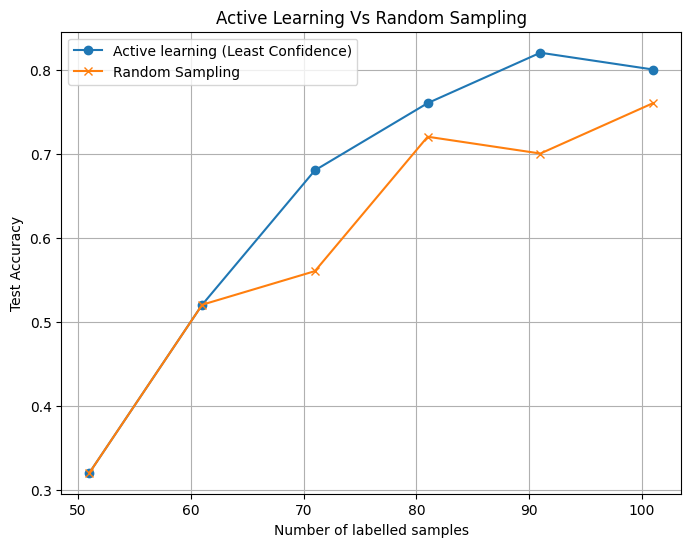

Final Comparison
Active Learning final accuracy: 0.8000
Random Sampling final accuracy: 0.7600
Accuracy Improvement: 0.0400


In [118]:
# TODO: Run active learning with random sampling (baseline)
n_labels_rand, acc_rand = run_active_learning_loop(X_seed, y_seed, X_pool, y_pool, X_test, y_test, strategy_func=random_sampling)

# TODO: Plot learning curves of active learning and random sampling wrt to number of samples
plt.figure(figsize = (8, 6))

plt.plot(n_labels_nc, acc_lc, marker = 'o', label = "Active learning (Least Confidence)")

plt.plot(n_labels_rand, acc_rand, marker = 'x', label = "Random Sampling")


plt.xlabel("Number of labelled samples")
plt.ylabel("Test Accuracy")


plt.title("Active Learning Vs Random Sampling")
plt.legend()
plt.grid(True)

plt.show()
# TODO: Print comparison summary for active learning and random sampling final accuracy
print("Final Comparison")

print(f"Active Learning final accuracy: {acc_lc[-1]:.4f}")
print(f"Random Sampling final accuracy: {acc_rand[-1]:.4f}")

improvement = acc_lc[-1] - acc_rand[-1]

print(f"Accuracy Improvement: {improvement:.4f}")

## Task 4: AI vs. AI (LLM & Noise Detection) (3 Marks)

**Objective:** Use LLMs for bulk labeling and detect hallucinations.

**Note:**

- Make an account at [open-router](https://openrouter.ai/) and get the API key.
- Use `google/gemini-2.5-flash-lite` (free tier) model as your LLM. Read the documentation on how to use it [here](https://openrouter.ai/google/gemini-2.5-flash-lite/api)
- Set environment variable using .env file and paste your API key in it.

### Part 4.1: LLM Pipeline with Few-Shot Prompting

Design a few-shot prompt with 3 examples from gold standard.
Send remaining unlabeled samples (~150) to Gemini API for labeling.

In [119]:

import os
import time
import json
import requests
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv('OPENROUTER_API_KEY')
SITE_URL = "http://localhost:8000"  #for OpenRouter rankings
SITE_NAME = "Student Lab Assignment"

MODEL_NAME = "google/gemini-2.5-flash-lite"

if not API_KEY:
    print("⚠ Warning: OPENROUTER_API_KEY not found. Please check your .env file.")


def generate_few_shot_prompt(review_text, examples):
    """
    Constructs a few-shot prompt with 3 gold examples + target review.

    Args:
        review_text (str): The review to be labeled
        examples (list): List of 3 example dictionaries with 'review' and 'label' keys

    Returns:
        str: Formatted prompt string
    """

    pass

def query_openrouter(review_text, examples):
    """
    Sends request to OpenRouter API with retry logic and parsing.

    Args:
        review_text (str): Review to classify
        examples (list): Few-shot examples (list of dicts with 'review' and 'label')

    Returns:
        str: Label ('Positive', 'Negative', or 'Neutral')
             Returns None if API fails or response is invalid

    Note:
        - Uses OpenRouter API endpoint: https://openrouter.ai/api/v1/chat/completions
        - Implements retry logic for rate limit errors (429)
        - Parses response from OpenRouter's chat completions format
    """
    url = "https://openrouter.ai/api/v1/chat/completions"

    # TODO: Set up headers:

    # TODO: Generate prompt using generate_few_shot_prompt()

    # TODO: Create payload dictionary:

    # TODO: Implement retry logic:

    # TODO: Parse successful response:

    pass

# --- MAIN EXECUTION ---

# TODO: Load gold standard examples for few-shot prompting

# TODO: Load remaining unlabeled reviews (~150, select last 150 from movie_reviews_300.csv)


# TODO: Query OpenRouter for each review
# Handle free tier requests per minute (RPM) limit of ~15

# TODO: Save LLM labels, in csv format with 'review' and 'label' columns

ModuleNotFoundError: No module named 'dotenv'

### Part 4.2: Noise Hunting (Cleanlab Logic)

Train a Logistic Regression model on LLM-labeled data.
Identify "High Confidence Disagreements" where the model is very confident (>0.80) but disagrees with the LLM label.

In [ ]:
def find_label_errors(llm_labels, model_probs, review_texts, threshold=0.90):
    """
    Detects high-confidence disagreements between model predictions and LLM labels.
    This implements Cleanlab logic: find cases where model is confident but disagrees with LLM.

    Args:
        llm_labels: List/array of labels from Gemini (numeric: 0=Negative, 1=Positive, 2=Neutral)
        model_probs: Probability matrix from Logistic Regression (shape: N_samples, N_classes)
        review_texts: List of review texts (for display)
        threshold: Confidence threshold (default 0.90)

    Returns:
        list: List of dictionaries with suspicious review information
              Each dict contains: 'index', 'text', 'llm_label', 'model_pred', 'confidence'
    """
    # TODO: Get model predictions from probabilities


    # TODO: Get model confidence (max probability) for each sample


    # TODO: Convert llm_labels to numeric if they are strings
    # Map 'Positive'->1, 'Negative'->0, 'Neutral'->2

    # TODO: Find disagreements where:
    #   Hint: disagreement_mask = (preds != llm_labels) & (confidences > threshold)

    # TODO: Create list of suspicious reviews with all relevant information (llm label, model prediction, confidence)


    # TODO: Sort by confidence (highest first) to find most egregious errors

    # TODO: Return list of suspicious reviews
    pass


# TODO: Load LLM labels in dataframe

# TODO: Vectorize LLM-labeled reviews (use same vectorizer from Task 3)

# TODO: Train Logistic Regression on LLM-labeled data
# Use same model configuration as Task 3 for consistency

# TODO: Get probabilities on the same data (self-check), shape should be (N_samples, N_classes)

# TODO: Find label errors using your function

# TODO: Print top 5 suspicious reviews (if <5, print all)

## Deliverables

**Submission Checklist:**
- [ ] Completed Jupyter Notebook with all tasks (Tasks 1-4)
- [ ] Include your label-studio annotation interface screenshot.
- [ ] gold_standard_100.csv
- [ ] weak_labels_200.csv
- [ ] llm_labels_150.json